In [5]:
#
# Advanced Robotics, 2024-2025
# Dr Paul Baxter
# Workshop Week 2
#
# code based on example: https://github.com/MJeremy2017/Reinforcement-Learning-Implementation/blob/master/GridWorld/gridWorld.py
# with description: https://towardsdatascience.com/reinforcement-learning-implement-grid-world-from-scratch-c5963765ebff
#
# Run with:     python3 lecture2-simulation.py
#
# May need following depedencies:
#   python -mpip install numpy
#
#
# Three classes in this file:
#  1. State: the board/maze (line 40)
#  2. Agent: a basic learning agent (state value iteration) (line 103)
#


import numpy as np
import matplotlib.pyplot as plt



In [6]:

# global variables
LOGGING = False         #set full logging to terminal or not...
L_ITERATIONS = 50       #number of learning iterations for Agent
EXPLORE = 0.3           #the explore proportion: (1-EXPLORE) for exloit

# maze states - leave alone for now...
BOARD_ROWS = 3
BOARD_COLS = 4
WIN_STATE = (0, 3)
LOSE_STATE = (1, 3)
START = (2, 0)          #third row, first column


In [7]:

##########################################################
# The maze environment
##########################################################
class State:
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False

    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif self.state == LOSE_STATE:
            return -1
        else:
            return 0

    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE):
            self.isEnd = True

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position
        """
        if action == "up":
            nxtState = (self.state[0] - 1, self.state[1])
        elif action == "down":
            nxtState = (self.state[0] + 1, self.state[1])
        elif action == "left":
            nxtState = (self.state[0], self.state[1] - 1)
        else:
            nxtState = (self.state[0], self.state[1] + 1)
        # if next state legal
        if (nxtState[0] >= 0) and (nxtState[0] <= 2):
            if (nxtState[1] >= 0) and (nxtState[1] <= 3):
                if nxtState != (1, 1):
                    return nxtState
        return self.state

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'X'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')



In [8]:

##########################################################
# Agent using basic value iteration
##########################################################
class Agent:

    def __init__(self):
        self.states = []
        self.numStates = []
        self.rewards = []
        self.cumulativeReward = []
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.lr = 0.2
        self.exp_rate = EXPLORE
        self.mean_moves = 0.0

        # initial state reward
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0  # set initial value to 0

    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                nxt_reward = self.state_values[self.State.nxtPosition(a)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        return State(state=position)

    def reset(self):
        self.states = []
        self.State = State()

    def play(self, rounds=10):
        i = 0
        print ("")
        print ("LEARNING START")
        stepCounter = 0
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                self.rewards.append(reward)
                # explicitly assign end state to reward values
                self.state_values[self.State.state] = reward  # this is optional
                print ("Episode ", i, ": ")
                print ("--------------------- End Reward", reward)
                print ("--------------------- Num Steps Used: ", stepCounter)
                for s in reversed(self.states):
                    reward = self.state_values[s] + self.lr * (reward - self.state_values[s])
                    self.state_values[s] = round(reward, 3)
                self.reset()
                self.numStates.append(stepCounter)
                stepCounter = 0
                i += 1
            else:
                stepCounter += 1
                action = self.chooseAction()
                # append trace
                self.states.append(self.State.nxtPosition(action))
                if (LOGGING):
                    print("  current position {} action {}".format(self.State.state, action))
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                if (LOGGING):
                    print ("    |--> next state", self.State.state)

    def showValues(self):
        print ("")
        for i in range(0, BOARD_ROWS):
            print ("-------------------------------------")
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print ("-------------------------------------")
        self.cumulativeRewards()
        
    def cumulativeRewards(self):
        self.cumulativeReward = [0]
        for r in self.rewards:
            self.cumulativeReward.append(self.cumulativeReward[-1] + r)
        print("")
        
    def resultsPlots(self):
        plt.plot(self.numStates, 'o')
        plt.title("Number of steps per episode")
        plt.xlabel("Episode number")
        plt.ylabel("Number of steps")
        plt.show()
        
        plt.plot(self.rewards, 'o')
        plt.title("Reward per episode")
        plt.xlabel("Episode number")
        plt.ylabel("Reward at end of episode")
        plt.show()
        
        plt.plot(self.cumulativeReward, 'o')
        plt.title("Cumulative reward")
        plt.xlabel("Episode number")
        plt.ylabel("Total reward")
        plt.show()




LEARNING START
Episode  0 : 
--------------------- End Reward -1
--------------------- Num Steps Used:  4
Episode  1 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  27
Episode  2 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  6
Episode  3 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  6
Episode  4 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  10
Episode  5 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  8
Episode  6 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  8
Episode  7 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  6
Episode  8 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  12
Episode  9 : 
--------------------- End Reward 1
--------------------- Num Steps Used:  5
Episode  10 : 
--------------------- End Reward 1
--------------------- Num Step

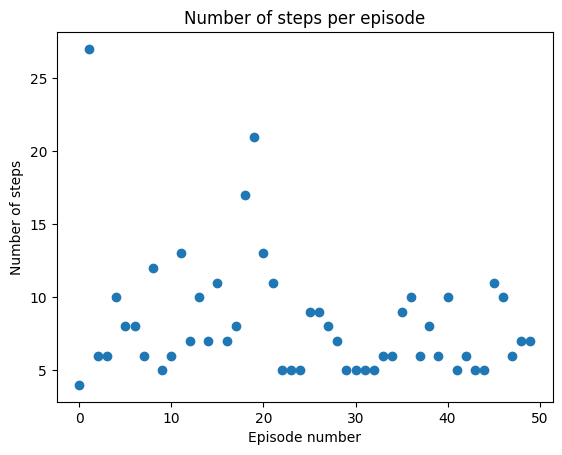

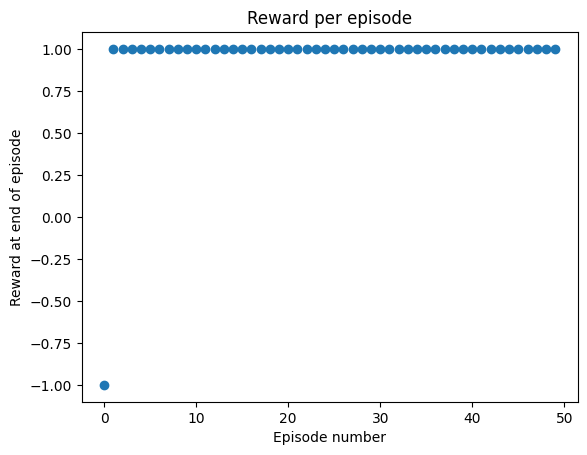

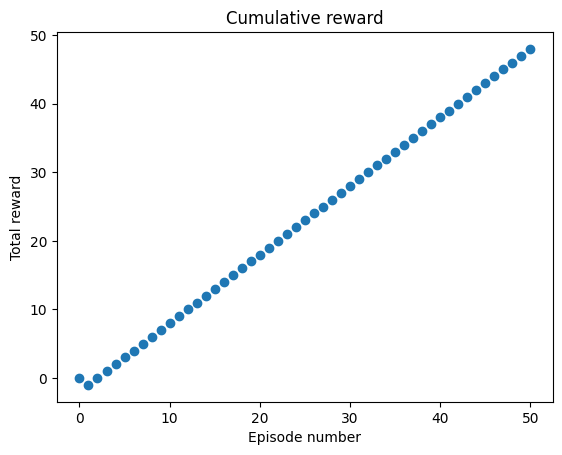

In [9]:
ag = Agent()
ag.play(L_ITERATIONS)

print ("_________________________________________________")
print ("")
print ("Final State Values:")
print(ag.showValues())
print ("")
ag.resultsPlots()
print("")
